In [1]:
import pandas as pd
import matplotlib as mp

%matplotlib inline

In [2]:
auctions = pd.read_csv('../data/auctions.csv.gzip',compression='gzip',\
                        usecols=['date','device_id','platform','ref_type_id','source_id'],\
                        dtype={'device_id':'int64','platform':'category','ref_type_id':'category','source_id':'category'},\
                        parse_dates=['date'])

In [3]:
auctions.sort_values(by=['device_id', 'date'], inplace=True)

In [4]:
auctions['next_date'] = auctions.groupby('device_id', as_index = False, sort=False)['date']\
                                              .transform(lambda x: x.shift(-1))
auctions = auctions.loc[(~auctions['next_date'].isnull())]
auctions['secs_to_next'] = (auctions['next_date'] - auctions['date'])\
                                        .transform(lambda x: round(x.total_seconds(), 2))
auctions['hour'] = auctions['date'].dt.hour
auctions['is_weekend'] = auctions['date'].dt.weekday >= 5

In [5]:
clicks = pd.read_csv('../data/clicks.csv.gzip',compression='gzip',\
                     parse_dates=['created'],\
                     dtype={'action_id':'category',\
                            'source_id':'category',\
                            'carrier_id':'category',\
                            'source_id':'category'})

In [6]:
clicks.shape

(26351, 20)

## En que horario del dia se hacen mas clicks?

In [7]:
clicks_on_auctions = clicks.merge(auctions, how='inner', left_on='ref_hash', right_on='device_id')
clicks_on_auctions = clicks_on_auctions.loc[((clicks_on_auctions['created'] >= clicks_on_auctions['date']) & (clicks_on_auctions['created'] <= clicks_on_auctions['next_date']))]

In [8]:
clicks_on_auctions.shape

(24723, 29)

In [9]:
clicks_on_auctions.head()

,advertiser_id,action_id,source_id_x,created,country_code,latitude,longitude,wifi_connection,carrier_id,trans_id,...,ref_hash,date,device_id,platform,ref_type_id,source_id_y,next_date,secs_to_next,hour,is_weekend
67,2,NaN,4,2019-03-06 22:42:12.755,6333597102633388268,1.205689,1.070234,False,1.0,iGgClCM9exiHF4K31g94XmvHEBSLKIY,...,1904083516767779093,2019-03-06 03:05:18.504699,1904083516767779093,1,1,5,2019-03-08 16:37:22.716724,221524.21,3,False
517,0,NaN,0,2019-03-08 10:24:30.641,6333597102633388268,1.218924,1.071209,False,4.0,MMHTOJ6qKAOeIH_Eywh1KIcCaxtO9oM,...,3086509764961796666,2019-03-08 10:24:23.903678,3086509764961796666,1,1,0,2019-03-08 14:58:25.463601,16441.56,10,False
611,0,NaN,0,2019-03-08 15:24:16.069,6333597102633388268,1.205689,1.070234,False,6.0,vIrEIdf9izUaWdAri6Ezk7T3nHFvNQU,...,6958163894863846647,2019-03-08 15:23:35.538873,6958163894863846647,1,1,0,2019-03-08 15:24:40.052461,64.51,15,False
673,2,NaN,3,2019-03-06 03:08:51.543,6333597102633388268,1.205689,1.070234,False,45.0,YaKxxEAs2UmZhSpRfiCO9Zpa82B_AKM,...,4368617728156436525,2019-03-06 03:07:56.250576,4368617728156436525,1,1,0,2019-03-06 03:24:02.524376,966.27,3,False
1176,2,NaN,3,2019-03-06 03:32:55.570,6333597102633388268,1.205689,1.070234,False,45.0,X5XTOcYQovkl6yadYdAD7xioVGU9jiY,...,4368617728156436525,2019-03-06 03:31:01.896438,4368617728156436525,1,1,0,2019-03-06 05:08:38.105531,5856.21,3,False


Text(0,0.5,'Cant. de encuestas')

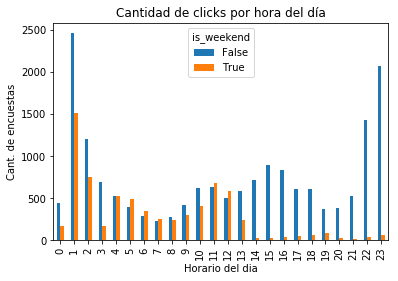

In [10]:
plot = clicks_on_auctions.groupby('is_weekend')['hour'].value_counts().unstack().transpose().plot.bar()
plot.set_title('Cantidad de clicks por hora del día')
plot.set_xlabel('Horario del dia')
plot.set_ylabel('Cant. de encuestas')

## Cuantos clicks se hace por subasta? 

In [12]:
clicks_on_auctions.groupby(['device_id', 'date'], as_index=False, sort=False)['trans_id'].count()['trans_id'].value_counts()

1    22324
2     1046
3       90
4        8
5        1
Name: trans_id, dtype: int64